Analyzing... : 100%|██████████| 30/30 [00:01<00:00, 18.93it/s]


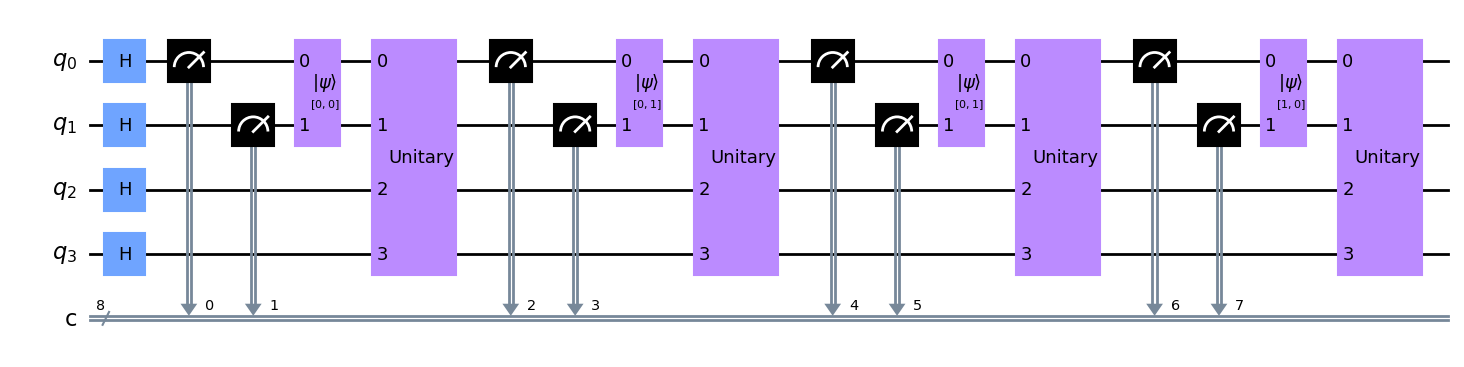

In [1]:
from qiskit.quantum_info import random_unitary
from qreservoirpy import QReservoir

encoder = {
    0: '00',
    1: '01',
    2: '10',
    3: '11'
}
SHOTS = 10000


class RandomUnitary(QReservoir):
    def __init__(self, n_qubits, **kwargs) -> None:
        super().__init__(n_qubits, **kwargs)
        self.operator = random_unitary(2 ** n_qubits)
    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep):
        circuit.measure([0, 1])
        circuit.initialize(encoder[timestep], [0, 1])
        circuit.append(self.operator, circuit.qubits)


res = RandomUnitary(n_qubits=4)

timestep = [0, 1, 1, 2]
timeseries = timestep * 10
states = res.run(timeseries, shots=SHOTS)

res.circuit(timestep, merge_registers=True).draw('mpl')



In [2]:
warmup = 0.1
warmup_len = int(len(states) * warmup)
x = states[:-1][warmup_len:]
target = timeseries[1:][warmup_len:]


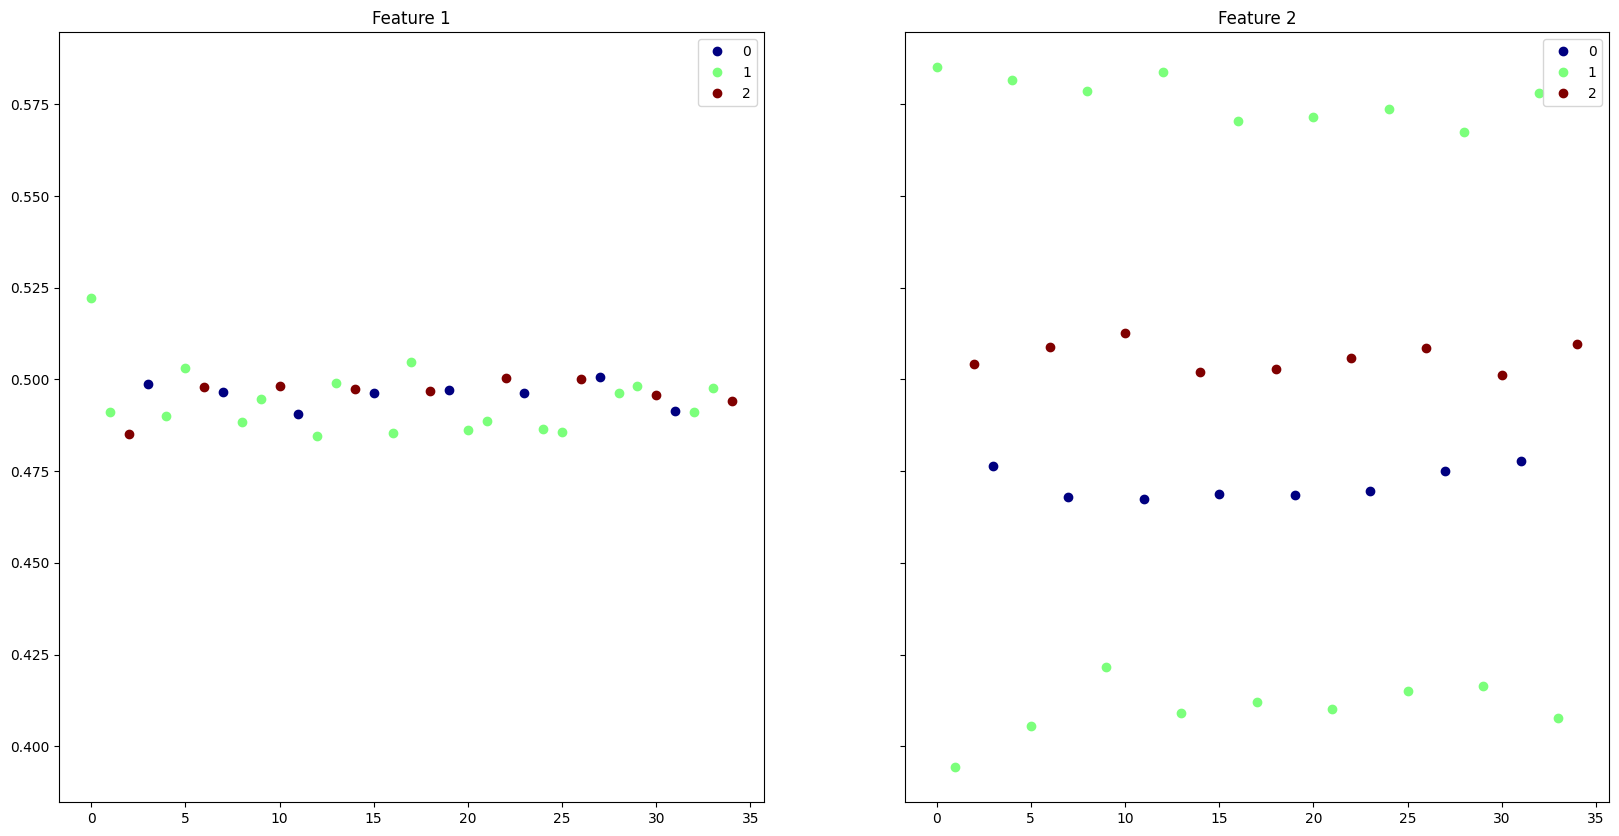

In [3]:
from qreservoirpy import state_plotter
fig, ax = state_plotter(x, target)

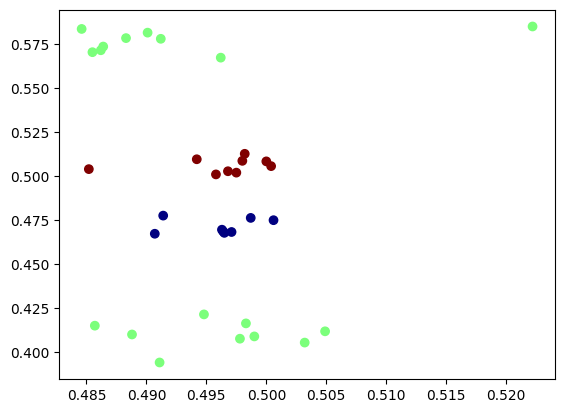

In [4]:
import matplotlib.pyplot as plt
import numpy as np
cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
plt.scatter(x[:, 0], x[:, 1], cmap=cmap, c=target)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
num_pred = 20

model = KNeighborsClassifier(n_neighbors=1)
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.33, random_state=42)

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

model.fit(x, target)

1.0


KNeighborsClassifier(n_neighbors=1)

In [6]:
predictions = res.predict(
    num_pred=20,
    model=model,
    from_series=timestep,
    shots=SHOTS
)

Predicting...: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


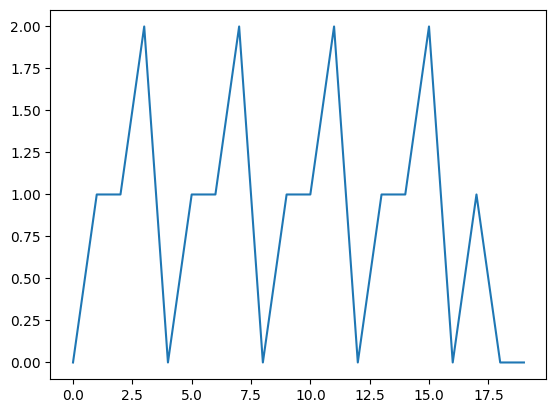

In [7]:
plt.plot(predictions)